# Data wrangling

This notebook loads the different datasets used in the analysis into a single NETCDF4 file, with descriptive attributes maintained for each dataset. Each dataset is regridded to the ICESat2 grid shape [304, 448] (x,y). The datasets used in this notebook are listed below. The output file is accessible in the [google cloud storage bucket](https://console.cloud.google.com/storage/browser/sea-ice-thickness-data) for this jupyter book and loaded in each notebook. 

## Details on each dataset
Detailed information about each of the datasets used to compile the final data product are provided below in the order they appear in the notebook workflow. The information provided here was last updated 08-21-2021. 

### ATLAS/ICESat-2 Monthly Gridded Sea Ice Freeboard
- **Product Type**: Northern hemisphere gridded monthly means
- **Download link**: 
    - NSIDC (recommended method): https://nsidc.org/data/ATL20
    - Our google storage bucket (provided for compatibility with this Jupyter Book): https://console.cloud.google.com/storage/browser/sea-ice-thickness-data
- **Reference**: Petty, A. A., R. Kwok, M. Bagnardi, A. Ivanoff, N. Kurtz, J. Lee, J. Wimert, and D. Hancock. 2021. ATLAS/ICESat-2 L3B Daily and Monthly Gridded Sea Ice Freeboard, Version 2. Northern hemisphere gridded monthly means. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. doi: https://doi.org/10.5067/ATLAS/ATL20.002. 08-21-2021.

### NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration
- **Variables used**: NOAA/NSIDC sea ice concentration CDR 
- **Download link**: https://nsidc.org/data/g02202
- **Reference**: Meier, W. N., F. Fetterer, A. K. Windnagel, and S. Stewart. 2021. NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4. Mean monthly aggregated, northern hemisphere. Boulder, Colorado USA. NSIDC: National Snow and Ice Data Center https://doi.org/10.7265/efmz-2t65. 08-21-2021.
- **NOTE**: Only the aggregated monthly dataset has latitude and longitude variables, so make sure you download this file! 

### NSIDC region mask and coordinate tools (psn25 v3)
- **Product names**: region_n.msk (region mask); psn25lons_v3.dat & psn25lats_v3.dat (coordinate tool)
- **Download links**: 
    - Region mask: https://nsidc.org/data/polar-stereo/tools_masks.html#region_masks
    - Coordinate tools: https://nsidc.org/data/polar-stereo/tools_geo_pixel.html
- **Reference**: unknown (if you know the reference for this product and would like to contribute it, please suggest an edit)

### ERA5 monthly averaged data on single levels
- **Variables used**: 2m temperature; Mean surface downward long-wave radiation flux
- **Product type**: Monthly averaged reanalysis 
- **Download link**: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means
- **Reference**: Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2019): ERA5 monthly averaged data on single levels from 1979 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). (Accessed on 16-08-2021), 10.24381/cds.f17050d7

### PIOMAS mean monthly ice thickness
- **Product Type**: Sea ice thickness (Volume per unit Area), monthly mean
- **Variables used**: Sea ice thickness (Volume per unit Area) monthly mean; Grid lon and lat for scalar fields (txt file) 
- **Download link**: http://psc.apl.uw.edu/research/projects/arctic-sea-ice-volume-anomaly/data/model_grid
- **Reference**: Zhang, Jinlun and D.A. Rothrock: Modeling global sea ice with a thickness and enthalpy distribution model in generalized curvilinear coordinates, Mon. Wea. Rev. 131(5), 681-697, 2003.
- **NOTE**: You'll want to download the heff format data product, not the text file. For some reason, just clicking on the gzipped file to unzip it raises an error on my computer that the archive is empty (which is not true!). You'll need to unzip the file using the command line; i.e. `gzip -d file.gz`

### Polar Pathfinder Daily 25 km EASE-Grid Sea Ice Motion Vectors
- **Product Type**: Ice motion Northern Hemisphere weekly means 
- **Download link**: https://nsidc.org/data/nsidc-0116
- **Reference**: Tschudi, M., W. N. Meier, J. S. Stewart, C. Fowler, and J. Maslanik. 2019. Polar Pathfinder Daily 25 km EASE-Grid Sea Ice Motion Vectors, Version 4. Ice motion Northern Hemisphere weekly means . Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. doi: https://doi.org/10.5067/INAWUWO7QH7B. 08-16-2021.


```{note}
Although you'll see an option to run this notebook in Binder, this notebook is **NOT** configured to run in Binder. If you want to wrangle the data yourself, each dataset used to compile the final data product can be downloaded from the links above. The final data product produced by this notebook can be downloaded from the google storage bucket associated with this jupyter book.
```

# 1) Import notebook dependencies

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
from datetime import date
import pyproj 
import scipy.interpolate 
from glob import glob
import matplotlib.pyplot as plt
from utils.read_data_utils import read_is2_data # This allows us to read the ICESAT2 data directly from the google storage bucket
from utils.wrangling_utils import create_empty_xr_ds # Allows you to fill in empty data to overcome data coverage issues 
from utils.wrangling_utils import is2_interp2d # Interpolate ICESat2 variables using CDR data 

# Ignore warnings in the notebook to improve display
import warnings
warnings.filterwarnings('ignore')

# 2) Read in data

## Define filepaths
Define filepaths to data on your local machine

In [2]:
cdr_path = ''         # NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration
regionMask_path = ''  # NSIDC region mask and coordinate tools (psn25 v3)
ERA5_path = ''        # ERA5 monthly averaged data on single levels
PIOMAS_path = ''      # PIOMAS mean monthly ice thickness
drift_path = ''       # Polar Pathfinder Daily 25 km EASE-Grid Sea Ice Motion Vectors

In [3]:
#Filepaths on Nicole's computer; cells removed in jupyter book

localDirectory = '../icesat2-book-data/'                         
cdr_path = localDirectory + 'CDR/'
regionMask_path = localDirectory + 'region_mask/'                
ERA5_path = localDirectory  + 'ERA5/ERA5_monthly_reanalysis.nc' 
PIOMAS_path = localDirectory + 'PIOMAS/'                         
drifts_path = localDirectory + 'seaice_motion_vectors/'           

## Set date range of interest
We'll restrict data to this date range, corresponding to years/months in our later analysis

In [4]:
start_date = "Nov 2018"
end_date = "Apr 2021"
date_range = pd.date_range(start=start_date, end=end_date, freq='MS') # MS indicates a time frequency of start of the month
print(date_range)

DatetimeIndex(['2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01'],
              dtype='datetime64[ns]', freq='MS')


## ICESat-2 gridded monthly means

In [5]:
is2_ds = read_is2_data(data_dir="IS2SITMOGR4")
#is2_ds = is2_ds.drop(["xgrid","ygrid"]) # Drop unneeded coords 

## Sea ice concentration 

In [6]:
## Old read_cdr_data function, for working with just a single file. Needed to update in order to read in NRT data, and assign lat/lon coord from CDR to NRT (not a coord for the non-aggreggated data)
## The NRT data is different because it doesn't come with lat/lon coords, and it is a single file for every month instead of one file for all months 

# def read_cdr_data(dataPath): 
#     """Reads in CDR data, renames coordinates, and sets lat/lon variables to coordinates
    
#      Args:
#          dataPath (str): path to CDR file 
         
#      Returns: 
#          cdr_ds (xr.Dataset): data 
#     """
    
#     cdr_ds = xr.open_dataset(dataPath)
#     cdr_ds = cdr_ds.rename({"tdim":"time","xgrid":"x","ygrid":"y"})  # Coords and dimensions have slightly different names. Rename so they match 
#     cdr_ds = cdr_ds.set_coords(["latitude","longitude"]) # Set lat and lon dimensions as coordinate variables
#     return cdr_ds

In [7]:
def read_cdr_data(filepaths, varname="cdr_seaice_conc_monthly"): 
    """Reads in CDR data, renames coordinates, and sets lat/lon variables to coordinates
    Selects one variable, defined by varname, and returns a DataArray with descriptive attributes for the entire dataset 
    
     Args:
         filepaths (list of str): paths to CDR files 
         varname (str, optional): name of variable to select (default to "cdr_seaice_conc_monthly", monthly sea ice concentration)
         
     Returns: 
         cdr_da (xr.DataArray): data 
    """
    
    def xr_rename_coords(da):
        da = da.rename({"tdim":"time","xgrid":"x","ygrid":"y"}) # Rename coordinates to match dimensions 
        return da
    
    cdr_ds = xr.open_mfdataset(filepaths, 
                               concat_dim=["time"], 
                               combine='nested', 
                               preprocess=xr_rename_coords)
    cdr_ds = cdr_ds.set_coords(["latitude","longitude"]) # Set lat and lon as coordinates 
    cdr_da = cdr_ds[varname] # Select one variable from Dataset
    cdr_da = cdr_da.sortby(variables="time", ascending=True) # Sort by time ascending

    # Add descriptive attributes from main Dataset 
    for key in ["metadata_link","contributor_name","contributor_role","license","summary"]:
        cdr_da.attrs[key] = cdr_ds.attrs[key] 
    cdr_da.attrs["reference"] = "Meier, W. N., F. Fetterer, A. K. Windnagel, and S. Stewart. 2021. NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4. Mean monthly aggregated, northern hemisphere. Boulder, Colorado USA. NSIDC: National Snow and Ice Data Center https://doi.org/10.7265/efmz-2t65. 08-21-2021."
    
    return cdr_da

In [8]:
# Paths to data 
cdr_nrt_filepaths = glob(cdr_path+"NRT/*.nc")  #NRT data, available as single netcdf files by month in 2021 
cdr_agg = cdr_path+"seaice_conc_monthly_nh_197811_202012_v04r00.nc" # Aggreggated monthly data, in one file 1979-2020

# Read in data 
cdr_da = read_cdr_data(filepaths=cdr_nrt_filepaths+[cdr_agg], varname="cdr_seaice_conc_monthly")
cdr_da = cdr_da.sel(time = date_range) # Select desired date range set at top of notebook 
cdr_da = cdr_da.where(cdr_da.latitude > is2_ds.latitude.min()) # Restrict to ICESat-2 latitude

### Remove flagged concentration data
Remove data on land and at the pole hole, which are assigned an aphysical value greater than 1

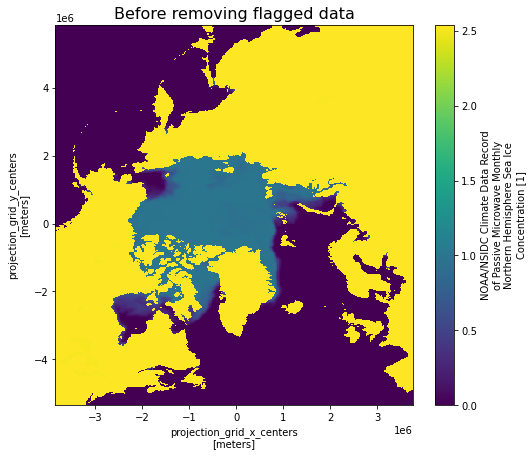

In [9]:
cdr_da.isel(time = 0).plot(figsize = (8,7))
plt.title("Before removing flagged data", fontsize = 16);

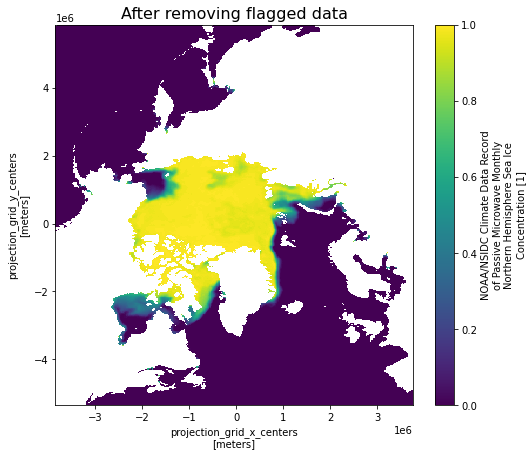

In [10]:
# Remove data > 1
cdr_da = cdr_da.where(cdr_da <= 1)

# Plot
cdr_da.isel(time = 0).plot(figsize = (8,7))
plt.title("After removing flagged data", fontsize = 16);

## NSIDC region mask and coordinate tools for the Arctic

In [11]:
def getRegionMask(dataPath): 
    """Gets NSIDC region mask for map projection
    
     Args:
         dataPath (str): path to NSIDC region mask
         
     Returns: 
         shapedMask (numpy array): NSIDC arctic region mask gridded to shape [448, 304]
         shapedLons (numpy array): longitudes gridded to shape [448, 304]
         shapedLats (numpy array): latitudes gridded to shape [448, 304] 
    """ 
    gridShape = [448, 304] # Shape of grid to reshape data to 
    
    regionMask = open(dataPath + '/sect_fixed_n.msk', 'rb') # Open region mask 
    shapedMask = np.reshape(np.fromfile(file = regionMask, dtype='uint8'), gridShape) # Reshape mask to grid shape
    
    maskLons = open(dataPath + '/psn25lons_v3.dat', 'rb') # Open region mask longitudes
    maskLats = open(dataPath + '/psn25lats_v3.dat', 'rb') # Open region mask latitudes
    shapedLons = np.reshape(np.fromfile(file = maskLons, dtype='<i4')/100000., gridShape) # Reshape longitudes to grid shape
    shapedLats = np.reshape(np.fromfile(file = maskLats, dtype='<i4')/100000., gridShape) # Reshape latitudes to grid shape

    return shapedMask, shapedLons, shapedLats

In [12]:
# Read in data
regionMask, maskLons, maskLats = getRegionMask(regionMask_path)

# Coords and attributes for region mask
# This will be used later to add as a coordinate to the final dataset 
regionMaskCoords = {'region_mask': (('y','x'), regionMask)}
regionMaskKeys = np.array([0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21])
regionMaskLabels = np.array(['Lakes, extended coast','non-region oceans', 'Sea of Okhotsk and Japan','Bering Sea','Hudson Bay','Gulf of St. Lawrence',
                    'Baffin Bay, Davis Strait & Labrador Sea','Greenland Sea', 'Barents Seas','Kara Sea','Laptev Sea','East Siberian Sea',
                    'Chukchi Sea','Beaufort Sea','Canadian Archipelago','Arctic Ocean','Land','Coast'])
regionMaskAttrs = {'description': 'NSIDC region mask for the Arctic', 
                   'keys': regionMaskKeys, 'labels' : 
                   regionMaskLabels, 'note': 'keys and labels ordered to match by index'}

## ERA5 climate reanalysis 

In [13]:
# Read data 
ERA5 = xr.open_dataset(ERA5_path)
ERA5 = ERA5.sel(time = date_range) # Select for date range of interest
ERA5 = ERA5.where(ERA5.latitude > is2_ds.latitude.min()) # Restrict to ICESat-2 latitude
ERA5 = ERA5.sel(expver = 1).drop('expver') # Remove weird variable

# Convert t2m temperature from Kelvin to Celcius 
tempCelcius = ERA5['t2m'] - 283.15
tempCelcius.attrs['units'] = 'C' # Change units attribute to C (Celcius)
tempCelcius.attrs['long_name'] = '2 meter temperature'
ERA5 = ERA5.assign(t2m = tempCelcius) #Add to dataset as a new data variable

# Add descriptive attributes 
ERA5.attrs = {'description': 'era5 monthly averaged data on single levels from 1979 to present', 
              'website': 'https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview', 
              'contact': 'copernicus-support@ecmwf.int',
              'citation': 'Copernicus Climate Change Service (C3S) (2017): ERA5: Fifth generation of ECMWF atmospheric reanalyses of the global climate . Copernicus Climate Change Service Climate Data Store (CDS), July 2020. https://cds.climate.copernicus.eu/cdsapp#!/home'}

## PIOMAS sea ice thickness 

In [14]:
def get_piomas_data(date_range, data_dir): 
    """ Read in a PIOMAS yearly files and convert to an xr.DataArray object 
    
    Args: 
        date_range (pandas DatetimeIndex): date range to grab data for 
        data_dir (str): directory containing data on local drive 
    
    Returns: 
        PIO_da (xr.DataArray): dataset object containing data for input date range
    
    """

    start_year = date_range[0].year
    end_year = date_range[-1].year

    pio_by_yr = []
    for year in range(start_year, end_year+1): 

        # Most recent year may not have a complete year of data
        # We need to reshape the data to match the number of months available, such that the shape of the numpy array is [month, 120, 360]
        i = 1
        while i <= 12: 
            data = open(data_dir + 'heff.H' + str(year), 'rb') 
            try: 
                pio_np = list(np.fromfile(file = data, dtype='f').reshape([i, 120, 360]))
                break
            except: 
                i += 1
        pio_by_yr += (pio_np)
        
    # Get latitude and longitude 
    gridP = np.loadtxt(data_dir + 'grid.dat.txt')
    lonsP = gridP[0:4320, :].flatten()
    lonsP = np.reshape(lonsP, [120,360])
    latsP = gridP[4320:, :].flatten()
    latsP = np.reshape(latsP, [120,360])

    # Load dataList as an xr.DataArray and add descriptive attributes and coordinates
    time = pd.date_range(start = str(start_year), end = str(end_year) + "-" + str(i), freq = 'MS')
    PIOMAS_da = xr.DataArray(pio_by_yr, 
                             dims = ['time','y','x'], 
                             coords = {'time': time, 'longitude': (('y','x'), lonsP), 'latitude': (('y','x'), latsP)}, 
                             attrs = {'units': 'meters', 
                                      'long_name': 'PIOMAS sea ice thickness', 
                                      'data_download': 'http://psc.apl.uw.edu/research/projects/arctic-sea-ice-volume-anomaly/data/', 
                                      'download_date': '08-2020',
                                       'citation': 'Zhang, J.L. and D.A. Rothrock, “Modeling global sea ice with a thickness and enthalpy distribution model in generalized curvilinear coordinates“, Mon. Weather Rev., 131, 845-861, 2003'}, 
                             name = "piomas_ice_thickness")
    PIOMAS_da = PIOMAS_da.sel(time = date_range)

    return PIOMAS_da

In [15]:
pio_da = get_piomas_data(date_range=date_range, data_dir=PIOMAS_path)
pio_da = pio_da.sel(time=date_range) # Select for date range of interest
pio_da = pio_da.where(pio_da.latitude > is2_ds.latitude.min()) # Restrict to ICESat-2 latitude 

## NSIDC sea ice motion vectors 
As of Aug 2021, this dataset does not have data for 2021, so I create an empty dataset filled with nans for Jan - Apr 2021

In [16]:
def get_uv_from_xy(xdrift, ydrift, lon):
        """convert the drift vectors to zonal/meridional, and calculate magnitude
        """
        alpha = lon*np.pi/180. #convert longitudes to radians 
        uvelT = ydrift*np.sin(alpha) + xdrift*np.cos(alpha)
        vvelT = ydrift*np.cos(alpha) - xdrift*np.sin(alpha)
        vectorMag = np.sqrt(uvelT**2 + vvelT**2)
        return uvelT, vvelT, vectorMag

def getDriftData(dataPath):
    """Gets weekly NSIDC sea ice drift data for the Arctic, resamples monthly, and returns a dataset
    
    Args: 
        dataPath (str): path to local directory of weekly drift data 

    Returns: 
        monthlyDrifts (xarray DataArray): sea ice drift data, resampled to monthly means, with descriptive coordinates and attributes
        
    Note: This function uses two different datasets from the NSIDC for drift in order to get the most recent data. Drift dataset from 1978-2018 was combined with quicklook drift dataset from 2019-present, maintaining attitributes of the 1978-2018 dataset
    """
    
    #combine nc weekly files into a single xarray dataset
    files = [xr.open_dataset(dataPath + f) for f in os.listdir(dataPath) if os.path.isfile(dataPath + f) and f.endswith('.nc')]
    weeklyDrifts = xr.concat(files, dim='time').sortby("time")

    #get transformed u,v variables and add to dataset
    uvelT, vvelT, vectorMag = get_uv_from_xy(weeklyDrifts.u, weeklyDrifts.v, weeklyDrifts.longitude)
    weeklyDrifts = weeklyDrifts.assign(drifts_uT = uvelT, drifts_vT = vvelT, drifts_magnitude = vectorMag)
    
    #resample to get monthly data 
    monthlyDrifts = weeklyDrifts.resample(time='MS', keep_attrs = True).mean()

    #convert to same time format as ICESat-2 
    monthlyDrifts = monthlyDrifts.assign_coords(time = [pd.to_datetime(date.strftime('%m-%d-%Y')) for date in monthlyDrifts.time.values])
    
    #add attributes
    monthlyDrifts.drifts_uT.attrs = {'description':'along-x component of the ice motion (u variable) converted to zonal/meridional', 'units':'cm/s', 'long_name':'sea ice x velocity'}
    monthlyDrifts.drifts_vT.attrs = {'description':'along-y component of the ice motion (v variable) converted to zonal/meridional', 'units':'cm/s', 'long_name':'sea ice y velocity'}
    monthlyDrifts.drifts_magnitude.attrs = {'long_name': 'drift vector magnitude', 'units':'cm/s'}
    monthlyDrifts.attrs['njkeeney comment'] = 'drift dataset from 1978-2018 was combined with quicklook drift dataset from 2019-present, maintaining attitributes of the 1978-2018 dataset'
    monthlyDrifts.attrs['citation'] = 'Tschudi, M., W. N. Meier, J. S. Stewart, C. Fowler, and J. Maslanik. 2019. Polar Pathfinder Daily 25 km EASE-Grid Sea Ice Motion Vectors, Version 4. Weekly sea ice motion. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. doi: https://doi.org/10.5067/INAWUWO7QH7B. July 2020.'
    for var in monthlyDrifts.data_vars: 
        if var not in ['drifts_magnitude','drifts_uT', 'drifts_vT']: 
            monthlyDrifts[var].attrs = weeklyDrifts[var].attrs #resampling function causes attributes to be lost, so add them back here
    
    return monthlyDrifts

In [17]:
drifts = getDriftData(dataPath=drifts_path)
drifts = drifts.where(drifts.latitude > drifts.latitude.min()) # Restrict to ICESat-2 latitude 

# Create empty dataset for 2021 since drifts is missing data 
drifts_empty_2021 = create_empty_xr_ds(xr_ds=drifts, start_date="2021-01", end_date="2021-04")
drifts = xr.merge([drifts, drifts_empty_2021])
drifts = drifts.sel(time=date_range) # Select for date range of interest

# 3) Regrid all datasets to ICESat-2 grid 
In order to merge all the datasets into a singe netcdf4 file, they need to be on the same grid.  

In [18]:
def regridToICESat2(dataArrayNEW, xptsNEW, yptsNEW, xptsIS2, yptsIS2):  
    """ Regrid new data to ICESat-2 grid 
    
    Args: 
        dataArrayNEW (xarray DataArray): DataArray to be gridded to ICESat-2 grid 
        xptsNEW (numpy array): x-values of dataArrayNEW projected to ICESat-2 map projection 
        yptsNEW (numpy array): y-values of dataArrayNEW projected to ICESat-2 map projection 
        xptsIS2 (numpy array): ICESat-2 longitude projected to ICESat-2 map projection
        yptsIS2 (numpy array): ICESat-2 latitude projected to ICESat-2 map projection
    
    Returns: 
        gridded (numpy array): data regridded to ICESat-2 map projection
    
    """
    gridded = []
    for i in range(len(dataArrayNEW.values)): 
        monthlyGridded = scipy.interpolate.griddata((xptsNEW.flatten(),yptsNEW.flatten()), dataArrayNEW.values[i].flatten(), (xptsIS2, yptsIS2), method = 'nearest')
        gridded.append(monthlyGridded)
    gridded = np.array(gridded)
    return gridded

## Sea ice concentration 
These datasets are on the same grid but have slightly different lat/lon values

In [19]:
#map projection from ICESat-2 data (can be viewed in is2.projection.attrs['srid'])
out_proj = 'EPSG:3411'
out_lons = is2_ds.longitude.values
out_lats = is2_ds.latitude.values

#initialize map projection and project data to it
mapProj = pyproj.Proj("+init=" + out_proj)
xptsIS2, yptsIS2 = mapProj(out_lons, out_lats)
xptsCDR, yptsCDR = mapProj(cdr_da.longitude.values, cdr_da.latitude.values)

#regrid data 
cdr_regridded = regridToICESat2(cdr_da, xptsCDR, yptsCDR, xptsIS2, yptsIS2)
cdr_regridded = xr.DataArray(data = cdr_regridded, 
                             dims = ['time', 'y', 'x'], 
                             coords = {'latitude': (('y','x'), out_lats), 'longitude': (('y','x'), out_lons), 'time': cdr_da.time.values}, 
                             name = cdr_da.name)
cdr_regridded = cdr_regridded.to_dataset()

## ERA5 climate reanalysis

In [20]:
# Choose data variables of interest 
ERA5Vars = ['t2m','msdwlwrf']

#initialize map projection and project data to it
mapProj = pyproj.Proj("+init=" + out_proj)
xptsERA, yptsERA = mapProj(*np.meshgrid(ERA5.longitude.values, ERA5.latitude.values))
xptsIS2, yptsIS2 = mapProj(out_lons, out_lats)

ERA5_list = []
for var in ERA5Vars: 
    ERA5gridded = regridToICESat2(ERA5[var], xptsERA, yptsERA, xptsIS2, yptsIS2) 
    ERAArray = xr.DataArray(data = ERA5gridded, 
                            dims = ['time', 'y', 'x'], 
                            coords = {'latitude': (('y','x'), out_lats), 'longitude': (('y','x'), out_lons), 'time':ERA5.time.values}, 
                            name = var)
    ERAArray.attrs = ERA5[var].attrs # Maintain descriptive attributes
    ERAArray = ERAArray.assign_attrs(ERA5.attrs)
    ERA5_list.append(ERAArray)
ERA5_regridded = xr.merge(ERA5_list)

## PIOMAS sea ice thickness 

In [21]:
#project data to ICESat-2 map projection
xptsPIO, yptsPIO = mapProj(pio_da.longitude.values, pio_da.latitude.values)

#regrid data 
pio_regridded = regridToICESat2(pio_da, xptsPIO, yptsPIO, xptsIS2, yptsIS2)
pio_regridded = xr.DataArray(data = pio_regridded, 
                             dims = ['time', 'y', 'x'], 
                             coords = {'latitude': (('y','x'), out_lats), 'longitude': (('y','x'), out_lons), 'time': pio_da.time.values}, 
                             name = pio_da.name)
pio_regridded = pio_regridded.assign_attrs(pio_da.attrs)
pio_regridded = pio_regridded.to_dataset()

## Sea ice motion vectors

In [22]:
#project data to ICESat-2 map projection
xptsDRIFTS, yptsDRIFTS = mapProj(drifts.longitude.isel(time=0).values, drifts.latitude.isel(time=0).values)

# Loop through variables of interest and regrid 
drifts_list = []
for var in ['drifts_uT', 'drifts_vT', 'drifts_magnitude']: 
    driftsGridded = regridToICESat2(drifts[var], xptsDRIFTS, yptsDRIFTS, xptsIS2, yptsIS2)

    driftsArray = xr.DataArray(data = driftsGridded, 
                               dims = ['time', 'y', 'x'], 
                               coords = {'latitude': (('y','x'), out_lats), 'longitude': (('y','x'), out_lons), "time": drifts.time.values}, 
                               name = var)

    driftsArray.attrs = drifts[var].attrs
    driftsArray = driftsArray.assign_attrs(drifts.attrs)
    drifts_list.append(driftsArray)

drifts_regridded = xr.merge(drifts_list)

# 4) Interpolate ICESat-2 variables 
Here, we'll interpolate some ICESat-2 variables using linear interpolation or a simple nearest neighbor interpolation function. Because ICESat-2 doesn't provide full monthly coverage, interpolating fills missing grid cells with a best guess based on surrounding data. This helps avoid sampling biases when performing time series analyses, with the cavaet that this interpolation method is subjective. <br><br>
In order to define the interpolation bounds (so that we don't try and interpolate over land, or other areas where there wouldn't be sea ice!), we use the NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration dataset to infer the location of the sea ice. By setting `interpolation=True`, the code calls an interpolation function that is defined in the `wrangling_utils.py` module.

In [23]:
is2_ds_interp = is2_interp2d(is2_ds, cdr_da, 
                             method="linear", # Interpolation method
                             interp_var=["ice_thickness","snow_depth","snow_density","freeboard","ice_type","ice_density"]) # Variables to interpolate

# 5) Compile and save final dataset
Now that all the data is on the same grid, we can use xarray to merge all the datasets. We'll also add the region mask as a coordinate.

## Combine datasets

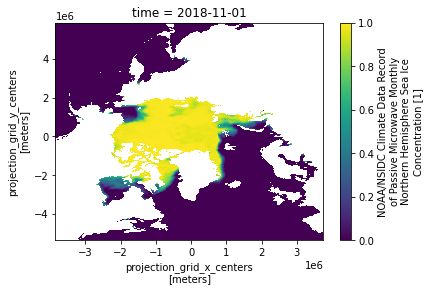

In [29]:
cdr_da.isel(time=0).plot()

In [33]:
cdr_regridded["cdr_seaice_conc_monthly"]

<xarray.DataArray 'cdr_seaice_conc_monthly' ()>
array(0.23213282, dtype=float32)

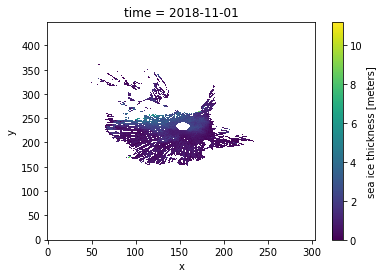

In [37]:
is2_ds["ice_thickness"].isel(time=0).plot()

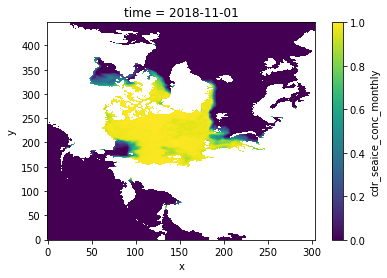

In [38]:
final_ds["cdr_seaice_conc_monthly"].isel(time=0).plot()

In [24]:
final_ds = xr.merge([is2_ds_interp, cdr_regridded, pio_regridded, ERA5_regridded, drifts_regridded])

## Add region mask as a coordinate to the final dataset
This allows the user to easily mask regions when analyzing the data. See the region masking notebook for more information on the utility of this.

In [25]:
final_ds = final_ds.assign_coords(coords=regionMaskCoords)
final_ds.region_mask.attrs = regionMaskAttrs
final_ds.attrs = {'description':'Data used in ICESat-2 jupyter book', 
                  'note': 'See individual data variables for references', 
                  'creation date': str(date.today())}
print(final_ds)

<xarray.Dataset>
Dimensions:                  (time: 30, y: 448, x: 304)
Coordinates:
  * time                     (time) datetime64[ns] 2018-11-01 ... 2021-04-01
    longitude                (y, x) float32 168.3 168.1 168.0 ... -10.18 -9.999
    latitude                 (y, x) float32 31.1 31.2 31.3 ... 34.68 34.58 34.47
    xgrid                    (y, x) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
    ygrid                    (y, x) float32 5.838e+06 5.838e+06 ... -5.338e+06
    region_mask              (y, x) uint8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Dimensions without coordinates: y, x
Data variables: (12/23)
    freeboard                (time, y, x) float32 nan nan nan ... nan nan nan
    freeboard_smoothed       (time, y, x) float64 nan nan nan ... nan nan nan
    ice_density              (time, y, x) float32 nan nan nan ... nan nan nan
    ice_density_smoothed     (time, y, x) float64 nan nan nan ... nan nan nan
    ice_thickness            (time, y, x) float32 nan nan nan ..

## Save data to local machine as a netcdf4 file
We also uploaded this same file to the google storage bucket. 

In [50]:
filename = 'icesat2-book-data.nc'
final_ds.to_netcdf(path=filename, format='NETCDF4', mode='w')
print('File ' + '"%s"' % filename + ' saved to directory ' + '"%s"' % os.getcwd())

final_ds.to_netcdf(path=localDirectory+"/"+filename, format='NETCDF4', mode='w')
print('File ' + '"%s"' % filename + ' saved to directory "' + '%s' % localDirectory+"/"+filename+"" )

File "icesat2-book-data.nc" saved to directory "/Users/nicolekeeney/code/icesat2-book"
File "icesat2-book-data.nc" saved to directory "../icesat2-book-data//icesat2-book-data.nc


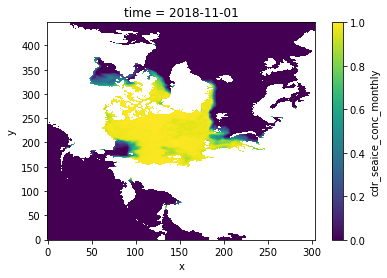

In [53]:
#final_ds["cdr_seaice_conc_monthly"].isel(time=0).plot()
xr.open_dataset("icesat2-book-data.nc")["cdr_seaice_conc_monthly"].isel(time=0).plot()